<a href="https://colab.research.google.com/github/AnnetVasileva/machineLearning/blob/main/Practical%202/Model_undersample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [369]:
import numpy as np
import pandas as pd
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras

In [362]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [633]:
# read in data
path = '/content/drive/MyDrive/ML_ECO/'
pickle_file = 'data_set_big.pkl'

with open(path + pickle_file, 'rb') as f:
  train_set =pickle.load(f) 

X = train_set['X']
y = train_set['y']
X.shape

(111680, 174)

In [634]:
undersample = RandomUnderSampler(0.5)#sampling_strategy='majority')
# fit and apply the transform
# split to train and test
X_train_full, X_test, y_train_full, y_test = train_test_split( X, y, 
                                                    test_size=0.1, 
                                                    random_state=42,
                                                    stratify = y)
X_train_full.shape
X_over, y_over = undersample.fit_resample(X_train_full, y_train_full)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [618]:
scaler = StandardScaler()
scaler.fit(X_over)

scaler_test = StandardScaler()
scaler_test.fit(X_test)

X_over = scaler.transform(X_over)
X_test = scaler_test.transform(X_test)

In [635]:
# split data
X_train, X_valid, y_train, y_valid = train_test_split( X_over, y_over, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify = y_over)

X_train.shape

(12770, 174)

In [636]:
scaler = StandardScaler()
scaler.fit(X_train)

scaler_test = StandardScaler()
scaler_test.fit(X_test)
scaler_valid = StandardScaler()
scaler_valid.fit(X_valid)

X_train = scaler.transform(X_train)
X_valid = scaler_valid.transform(X_valid)
X_test = scaler_test.transform(X_test)

In [637]:
(y_train).sum()/len(y_train)

0.33335943617854347

In [621]:
y_valid.sum()/len(y_valid)

0.4997651479567872

In [653]:
#build basic model

# correct bias
total = len(y_train)
pos = y_train.sum()
neg = total - pos
initial_bias = np.log([pos/neg])
initial_bias =0



model = keras.models.Sequential()
model.add(keras.layers.Dense(512,input_dim=X.shape[1],  activation="tanh",  kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(rate=0.8))
model.add(keras.layers.Dense(256, activation="tanh",  kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(rate=0.5))
#model.add(keras.layers.Dense(128, activation="relu",  kernel_initializer="he_normal"))
#model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=tf.keras.initializers.Constant(initial_bias)))


In [654]:
# this should make sgd to be able to varry the learning rate
# taken from keras example
first_decay_steps = 100
initial_learning_rate = 0.1
lr_decayed_fn = (
  tf.keras.experimental.CosineDecayRestarts(
      initial_learning_rate,
      first_decay_steps))
opt = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn)

In [655]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
EPOCH = 150
BATCH_SIZE = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer= opt,
              #keras.optimizers.Adam(lr=0.0001),
              metrics=METRICS)

In [656]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH,
                    callbacks=[early_stopping],
                    validation_data=(X_valid, y_valid))
                    #class_weight=class_weight)

Epoch 1/150
128/128 [==============================] - 4s 16ms/step - loss: 0.7922 - tp: 695.2248 - fp: 1239.3566 - tn: 3063.9380 - fn: 1500.2403 - accuracy: 0.5677 - precision: 0.3615 - recall: 0.3582 - auc: 0.5192 - val_loss: 0.6419 - val_tp: 63.0000 - val_fp: 116.0000 - val_tn: 2013.0000 - val_fn: 1001.0000 - val_accuracy: 0.6502 - val_precision: 0.3520 - val_recall: 0.0592 - val_auc: 0.5432
Epoch 2/150
128/128 [==============================] - 1s 10ms/step - loss: 0.6613 - tp: 240.4341 - fp: 451.3876 - tn: 3858.9380 - fn: 1948.0000 - accuracy: 0.6279 - precision: 0.3398 - recall: 0.1163 - auc: 0.5227 - val_loss: 0.6312 - val_tp: 6.0000 - val_fp: 7.0000 - val_tn: 2122.0000 - val_fn: 1058.0000 - val_accuracy: 0.6665 - val_precision: 0.4615 - val_recall: 0.0056 - val_auc: 0.5636
Epoch 3/150
128/128 [==============================] - 1s 10ms/step - loss: 0.6392 - tp: 134.8682 - fp: 197.6434 - tn: 4149.5969 - fn: 2016.6512 - accuracy: 0.6646 - precision: 0.4303 - recall: 0.0548 - auc: 

In [396]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0,1])
    else:
      plt.ylim([0,1])

    plt.legend()

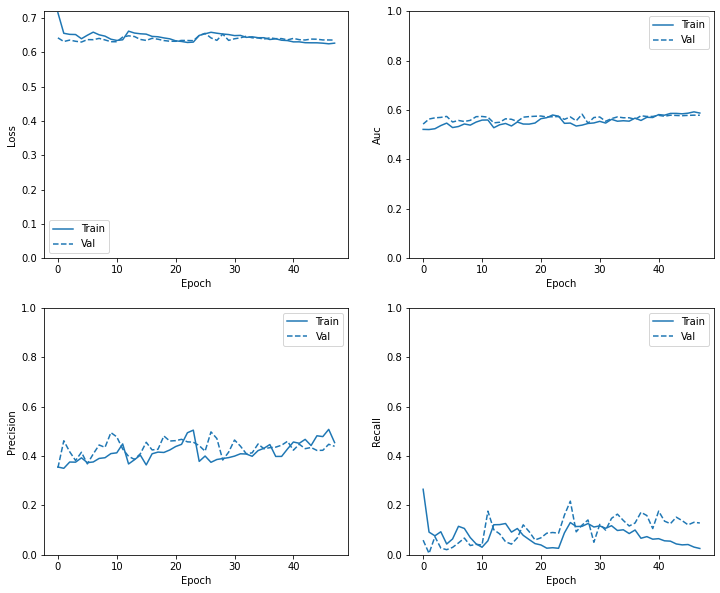

In [657]:
plot_metrics(history)

In [491]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
  auc_score = sklearn.metrics.roc_auc_score(labels, predictions)
  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
  plt.plot([0, 100], [0, 100], linestyle='--', lw=2, color='r',
      label='Chance', alpha=.8)

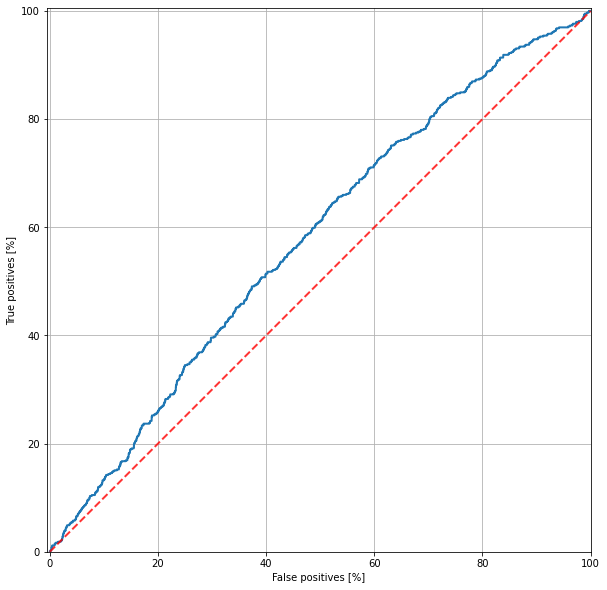

In [658]:
results = model.predict(X_test)
plot_roc("Train Baseline", y_test, results, color=colors[0])


In [659]:
model.evaluate(X_test, y_test)

349/349 [==============================] - 3s 6ms/step - loss: 0.4444 - tp: 50.0000 - fp: 671.0000 - tn: 9906.0000 - fn: 541.0000 - accuracy: 0.8915 - precision: 0.0693 - recall: 0.0846 - auc: 0.5753


[0.44438135623931885,
 50.0,
 671.0,
 9906.0,
 541.0,
 0.8914756178855896,
 0.06934812664985657,
 0.08460237085819244,
 0.5753107070922852]

In [674]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0,  max_iter=1e5, penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.2, warm_start = True).fit(X_train, y_train)
res_lr = clf.predict(X_test)

In [675]:
clf.score(X_test,y_test)

0.9200393982808023

In [677]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,res_lr)

array([[10240,   337],
       [  556,    35]])

In [678]:
from sklearn.metrics import classification_report
print(classification_report(y_test,res_lr))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     10577
           1       0.09      0.06      0.07       591

    accuracy                           0.92     11168
   macro avg       0.52      0.51      0.52     11168
weighted avg       0.90      0.92      0.91     11168



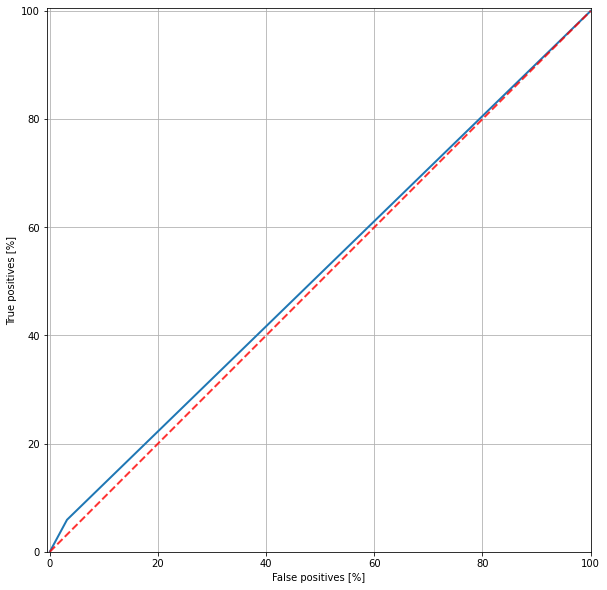

In [679]:
plot_roc("Train Baseline", y_test, res_lr, color=colors[0])